In [1]:
from copy import deepcopy
import math
import random
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import numpy as np

In [2]:
class ABCMatrix:
    def __init__(self, matrix, n, m):
        self._matrix = matrix
        self._n = n
        self._m = m

    def matrix(self):
        return self._matrix

    def n(self):
        return self._n

    def m(self):
        return self._m

    def trace(self):
        pass

    def det(self):
        pass

    def __getitem__(self, idx):
        pass

    def __add__(self, val):
        pass

    def __mul__(self, val):
        pass

    def __repr__(self):
        return f'ABCMatrix(matrix={self.matrix()}, n={self.n()}, m={self.m()})'


class DenseMatrix(ABCMatrix):
    def __init__(self, matrix, n=None, m=None):
        if not (n is None and m is None):
            assert len(matrix) == n and len(matrix[0]) == m
        else:
            n, m = len(matrix), len(matrix[0])
        super().__init__(matrix, n, m)
        self.coefs = None

    def __getitem__(self, idx):
        return self.matrix()[idx]

    def __repr__(self):
        return f'DenseMatrix(matrix={self.matrix()}, n={self.n()}, m={self.m()})'


    def trace(self):
        result = 0
        n, m = self.n(), self.m()
        assert n == m, "Матрица должна быть квадратной"
        for i in range(n):
            result += self.matrix()[i][i]
        return result

    def __add__(self, val):
        assert self.n() == val.n() and self.m() == val.m(), "Размеры матриц должны совпадать"
        matrix = [[0] * self.m() for _ in range(self.n())]
        for i in range(self.n()):
            for j in range(self.m()):
                matrix[i][j] = self.matrix()[i][j] + val.matrix()[i][j]
        return DenseMatrix(matrix)
    
    def __sub__(self, val):
        assert self.n() == val.n() and self.m() == val.m(), "Размеры матриц должны совпадать"
        matrix = [[0] * self.m() for _ in range(self.n())]
        for i in range(self.n()):
            for j in range(self.m()):
                matrix[i][j] = self.matrix()[i][j] - val.matrix()[i][j]
        return DenseMatrix(matrix)

    def __mul__(self, val):
        if isinstance(val, (int, float)):
            matrix = [[0] * self.m() for _ in range(self.n())]
            for i in range(self.n()):
                for j in range(self.m()):
                    matrix[i][j] = self.matrix()[i][j] * val
            return DenseMatrix(matrix)
        else:
            assert self.m() == val.n(), "Количество столбцов первой матрицы должно совпадать с количеством строк второй"
            matrix = [[0] * val.m() for _ in range(self.n())]
            
            for i in range(self.n()):
                for j in range(val.m()):
                    for k in range(val.n()):
                        matrix[i][j] += self.matrix()[i][k] * val.matrix()[k][j]
            
            return DenseMatrix(matrix)

    def det(self, matrix=None):
        if matrix is None:
            matrix = self
        if matrix.n() == 1:
            return self[0][0]
        if matrix.n() == 2:
            return matrix[0][0] * matrix[1][1] - matrix[0][1] * matrix[1][0]
        det = 0
        for col in range(matrix.n()):
            minor = [[matrix[i][j] for j in range(matrix.n()) if j != col] for i in range(1, matrix.n())]
            det += ((-1) ** col) * self[0][col] * self.det(DenseMatrix(minor))
        return det

    def det_gauss(self):
        assert self.n() == self.m()
        det = 1
        matrix = deepcopy(self.matrix())
        for i in range(self.n()):
            max_row = i
            for k in range(i + 1, self.n()):
                if abs(matrix[k][i]) > abs(matrix[max_row][i]):
                    max_row = k
            if max_row != i:
                matrix[i], matrix[max_row] = matrix[max_row], matrix[i]
                det *= -1
            for j in range(i + 1, self.n()):
                if matrix[i][i] == 0:
                    return 0
                factor = matrix[j][i] / matrix[i][i]
                for z in range(i, self.n()):
                    matrix[j][z] -= factor * matrix[i][z]
       
        for i in range(self.n()):
            det *= matrix[i][i]
        return det
    
    def gauss_solver(self, b):
        assert self.n() == self.m(), "Матрица должна быть квадратной"
        if isinstance(b, list):
            assert len(b) == self.n(), "Размерность вектора b должна совпадать с количеством строк матрицы"
            augmented_matrix = deepcopy(self.matrix())
            for i in range(self.n()):
                augmented_matrix[i].append(b[i])
        elif isinstance(b, DenseMatrix):
            assert b.m() == 1 and b.n() == self.n(), "Размерность вектора b должна совпадать с количеством строк матрицы"
            augmented_matrix = deepcopy(self.matrix())
            for i in range(self.n()):
                augmented_matrix[i].append(b[i][0])
        else:
            raise TypeError("Неподдерживаемый формат")

        n = self.n()

        # Прямой ход (приведение к верхнетреугольному виду)
        for i in range(n):
            max_row = i
            for k in range(i + 1, n):
                if abs(augmented_matrix[k][i]) > abs(augmented_matrix[max_row][i]):
                    max_row = k

            # Переставляем строки
            augmented_matrix[i], augmented_matrix[max_row] = augmented_matrix[max_row], augmented_matrix[i]

            if augmented_matrix[i][i] == 0:
                return None  # Определитель равен 0

            pivot_element = augmented_matrix[i][i]
            for j in range(i, n + 1):
                augmented_matrix[i][j] /= pivot_element

            # Обнуляем элементы ниже
            for k in range(i + 1, n):
                factor = augmented_matrix[k][i]
                for j in range(i, n + 1):
                    augmented_matrix[k][j] -= factor * augmented_matrix[i][j]

        # Обратный ход (нахождение решений)
        x = [0] * n
        for i in range(n - 1, -1, -1):
            x[i] = augmented_matrix[i][n]
            for j in range(i + 1, n):
                x[i] -= augmented_matrix[i][j] * x[j]

        return DenseMatrix([[val] for val in x], n, 1)
    
    @staticmethod
    def I(n):
        matrix = [[1.0 if i == j else 0.0 for j in range(n)] for i in range(n)]
        return DenseMatrix(matrix)

    def means(self):
        return [sum(self[i][j] for i in range(self.n())) / self.n() for j in range(self.m())]
    
    def center(self):
        centers_by_columns = self.means()
        mean_X = DenseMatrix(list(centers_by_columns for _ in range(self.n())))
        return self - mean_X

    def T(self):
        matrix_T = list(zip(*self.matrix()))
        return DenseMatrix(matrix_T)
    
    def covariance_matrix(self):
        X_centered = self.center()
        n = X_centered.n()
        X_T = X_centered.T()
        C = (X_T * X_centered) * (1 / (n - 1))
        return C
    
    def poly_char(self):
        assert self.n() == self.m(), "Матрица должна быть квадратной"
        n = self.n()
        coeffs = [0] * (n + 1)
        coeffs[n] = 1
        I = DenseMatrix.I(n)
        M = DenseMatrix(deepcopy(self.matrix()))
        
        for k in range(1, n + 1):
            # Вычисляем коэффициент
            c_k = -M.trace() / k
            coeffs[n - k] = c_k
            
            # Обновляем матрицу M для следующей итерации
            if k < n:
                M = self * (M + I * c_k)

        self.coefs = coeffs
        return coeffs
    
    def poly_eval(self, lambd):
        if self.coefs is None:
            self.poly_char()
        result = 0
        for i in range(len(self.coefs)):
            result += self.coefs[i] * lambd ** i
        return result
    
    def eigenvalues(self, tol: float = 1e-6, grid=1000, steps=100):
        n = self.n()
        trace = self.trace()
        left = 0
        right = trace + 1

        num_roots = n
        roots = []
        intervals = []
        xs = [left + (right - left) * i / grid for i in range(grid + 1)]
        prev_val = self.poly_eval(xs[0])
        for i in range(1, len(xs)):
            val = self.poly_eval(xs[i])
            if prev_val * val < 0:
                intervals.append((xs[i-1], xs[i]))
            prev_val = val
            if len(intervals) == num_roots:
                break
    
        # Бисекция на найденных интервалах
        for a, b in intervals:
            for _ in range(steps):
                mid = (a + b) / 2
                f_a = self.poly_eval(a)
                f_mid = self.poly_eval(mid)
                if abs(f_mid) < tol:
                    break
                if f_a * f_mid < 0:
                    b = mid
                else:
                    a = mid
            roots.append((a + b) / 2)
        return roots
    
    def norm(self):
        assert self.m() == 1, "Норма определена только для векторов"
        sum_sq = sum(self._matrix[i][0] ** 2 for i in range(self.n()))
        return sum_sq ** 0.5
    
    def gauss_solver_eigenvector(self, lambda_approx, epsilon=1e-5):
        assert self.n() == self.m(), "Матрица должна быть квадратной"
        
        n = self.n()
        
        augmented_matrix = deepcopy(self.matrix())
        for i in range(n):
            augmented_matrix[i][i] = augmented_matrix[i][i] - lambda_approx

        pivot_col_indices = [-1] * n
        
        current_col = 0
        for current_row in range(n):
            if current_col >= n: break # Больше нет столбцов для выбора ведущего элемента
                
            pivot_row = current_row
            max_abs_val = abs(augmented_matrix[current_row][current_col])
            for k in range(current_row + 1, n):
                if abs(augmented_matrix[k][current_col]) > max_abs_val:
                    max_abs_val = abs(augmented_matrix[k][current_col])
                    pivot_row = k

            if pivot_row != current_row:
                augmented_matrix[current_row], augmented_matrix[pivot_row] = augmented_matrix[pivot_row], augmented_matrix[current_row]

            pivot_value = augmented_matrix[current_row][current_col]

            # Проверка, является ли ведущий элемент нулевым
            if abs(pivot_value) < epsilon:
                current_col += 1
                continue

            pivot_col_indices[current_row] = current_col

            # Обнуление элементов ниже
            for i in range(current_row + 1, n):
                factor = augmented_matrix[i][current_col] / pivot_value
                for j in range(current_col, n):
                    augmented_matrix[i][j] -= factor * augmented_matrix[current_row][j]
                augmented_matrix[i][current_col] = 0.0

            current_col += 1

        rank = sum(1 for i in range(n) if any(abs(augmented_matrix[i][j]) > epsilon for j in range(n)))

        if rank == n:
             return None # Не тривиальное решение

        x = [0] * n

        # Не ведущие переменные
        pivot_cols_set = set(idx for idx in pivot_col_indices if idx != -1)
        free_var_indices = sorted([j for j in range(n) if j not in pivot_cols_set])

        # Устанавливаем свободную переменную
        free_var_to_set = free_var_indices[-1]
        x[free_var_to_set] = 1.0
        
        for i in range(n - 1, -1, -1):
            pivot_col_for_row_i = pivot_col_indices[i]

            if pivot_col_for_row_i == -1:
                continue

            pivot_val = augmented_matrix[i][pivot_col_for_row_i]

            if abs(pivot_val) < epsilon:
                 continue

            sum_known_terms = 0.0
            for j in range(pivot_col_for_row_i + 1, n):
                sum_known_terms += augmented_matrix[i][j] * x[j]
                
            x[pivot_col_for_row_i] = -sum_known_terms / pivot_val


        # Нормализация
        norm_sq = sum(val**2 for val in x)
        if norm_sq < epsilon**2:
            return None # Нулевой вектор

        norm = norm_sq**0.5
        x_normalized = [val / norm for val in x]

        eigenvector_matrix_data = [[val] for val in x_normalized]
        return DenseMatrix(eigenvector_matrix_data, n, 1)
    
    @staticmethod
    def concatenate_vectors(*vectors):
        assert len(vectors) > 0
        assert len(set(map(lambda x: (x.m(), x.n()), vectors))) == 1
        assert (vectors[0].n() == 1) ^ (vectors[0].m() == 1)
        if vectors[0].n() == 1:
            matrix = [[0] * vectors[0].m() for _ in range(len(vectors))]
            for idx in range(len(vectors)):
                for j in range(vectors[0].m()):
                    matrix[idx][j] = vectors[idx][0][j]
        else:
            matrix = [[0] * len(vectors) for _ in range(vectors[0].n())]
            for idx in range(len(vectors)):
                for i in range(vectors[0].n()):
                    matrix[i][idx] = vectors[idx][i][0]
        return DenseMatrix(matrix)
    
    @staticmethod
    def cut_by_vector(matrix):
        vectors = []
        for j in range(matrix.m()):
            vectors.append(DenseMatrix([[matrix[i][j]] for i in range(matrix.n())]))
        return vectors


In [3]:
def gauss_solver(A: DenseMatrix, b: DenseMatrix) -> DenseMatrix:
    """
    Вход:
    A: матрица коэффициентов (n × n)
    b: вектор правых частей (n × 1)
    Выход:
    list[DenseMatrix]: список базисных векторов решения системы
    Raises:
    ValueError: если система несовместна
    """
    # Используем метод Гаусса из matrix.py
    result = A.gauss_solver(b)
    if result is None:
        raise ValueError("Система несовместна или имеет бесконечно много решений")
    return result

In [4]:
gauss_solver(DenseMatrix([[2, 3], [4, 7]]), DenseMatrix([[8], [18]]))

DenseMatrix(matrix=[[1.0], [2.0]], n=2, m=1)

In [5]:
gauss_solver(DenseMatrix([[2, 3, 1], [4, 5, 2], [2, 1, 3]]), DenseMatrix([[11], [21], [13]]))

DenseMatrix(matrix=[[3.0], [1.0000000000000002], [2.0000000000000004]], n=3, m=1)

In [6]:
gauss_solver(DenseMatrix([[2, 1, 1, 1], [3, 5, 2, 1], [1, 3, 4, 2], [4, 2, 3, 5]]), DenseMatrix([[10], [24], [23], [37]]))

DenseMatrix(matrix=[[0.37735849056603765], [3.301886792452831], [0.4150943396226401], [5.528301886792454]], n=4, m=1)

In [7]:
def center_data(X: DenseMatrix) -> DenseMatrix:
    """
    Вход: матрица данных X (n × m)
    Выход: центрированная матрица X_centered (n × m)
    """
    return X.center()

In [8]:
center_data(DenseMatrix([[1, 2, 3], [4, 5, 6], [7, 8, 9]]))

DenseMatrix(matrix=[[-3.0, -3.0, -3.0], [0.0, 0.0, 0.0], [3.0, 3.0, 3.0]], n=3, m=3)

In [9]:
def covariance_matrix(X_centered: DenseMatrix) -> DenseMatrix:
    """
    Вход: центрированная матрица X_centered (n × m)
    Выход: матрица ковариаций C (m × m)
    """
    return X_centered.covariance_matrix()

In [10]:
covariance_matrix(DenseMatrix([[1, 2, 3], [4, 5, 6], [7, 8, 9]]))

DenseMatrix(matrix=[[9.0, 9.0, 9.0], [9.0, 9.0, 9.0], [9.0, 9.0, 9.0]], n=3, m=3)

In [11]:
def find_eigenvalues(C: DenseMatrix, tol: float = 1e-6, grid=1000) -> list[float]:
    return C.eigenvalues(tol=tol, grid=grid)

In [12]:
evals = find_eigenvalues(DenseMatrix([[2, 1, 1],
 [1, 2, 1],
 [1, 1, 1]]), grid=10000)
evals

[0.26794921875, 0.9999996093750001, 3.7320508300781254]

In [13]:
def find_eigenvectors(C: DenseMatrix, eigenvalues: list[float]) -> list[DenseMatrix]:
    """
    Вход:
    C: матрица ковариаций (m × m)
    eigenvalues: список собственных значений
    Выход: список собственных векторов (каждый вектор - объект DenseMatrix)
    """
    evecs = []
    for eival in eigenvalues:
        evecs.append(C.gauss_solver_eigenvector(lambda_approx=eival))
    return DenseMatrix.concatenate_vectors(*evecs)

In [14]:
find_eigenvectors(DenseMatrix([[2, 1, 1],
 [1, 2, 1],
 [1, 1, 1]]), evals).matrix()

[[-0.3250575861415274, -0.7071066430797679, 0.6279630247328335],
 [-0.32505758614152747, 0.7071069192933003, 0.6279630378529635],
 [0.8880738321691992, 0.0, 0.4597008403939113]]

In [15]:
def explained_variance_ratio(eigenvalues: list[float], k: int) -> float:
    """
    Вход:
    eigenvalues: список собственных значений
    k: число компонент
    Выход: доля объяснённой дисперсии
    """
    eigenvalues_sorted = sorted(eigenvalues, reverse=True)
    return sum(eigenvalues_sorted[:k]) / sum(eigenvalues_sorted)

In [16]:
explained_variance_ratio(evals, 2)

0.9464101525866315

In [17]:
matrix = [
    [23, 54, 12, 78, 91, 34, 67, 88],
    [11, 87, 45, 61, 33, 99, 5, 72],
    [90, 3, 77, 29, 49, 17, 82, 55],
    [66, 42, 19, 88, 51, 76, 30, 9],
    [4, 37, 59, 10, 64, 81, 28, 93],
    [70, 15, 98, 2, 25, 58, 41, 36],
    [50, 80, 20, 40, 60, 10, 30, 90],
    [13, 26, 39, 52, 65, 78, 91, 4],
    [85, 19, 32, 45, 58, 71, 84, 97],
    [1, 12, 23, 34, 45, 56, 67, 78],
    [33, 66, 99, 22, 55, 88, 11, 44],
    [95, 84, 73, 62, 51, 40, 29, 18],
    [22, 33, 44, 55, 66, 77, 88, 99],
    [16, 32, 48, 64, 80, 96, 12, 28],
    [75, 5, 15, 25, 35, 45, 55, 65],
    [47, 38, 29, 10, 1, 92, 83, 74]
]

In [18]:
def pca(X: DenseMatrix, k: int) -> tuple[DenseMatrix, float]:
    """
    Вход:
    X: матрица данных (n × m)
    k: число главных компонент
    Выход:
    X_proj: проекция данных (n × k)
    : доля объяснённой дисперсии
    """
    # 1. Центрирование
    # X_centered = X.center()
    X_centered = center_data(X)
    # 2. Ковариационная матрица
    # C = (X_centered.T() * X_centered) * (1 / (X_centered.n() - 1))
    C = covariance_matrix(X_centered)
    # 3. Собственные значения и векторы
    eigenvalues = find_eigenvalues(C)
    eigenvectors = DenseMatrix.cut_by_vector(find_eigenvectors(C, eigenvalues))
    # 4. Сортировка по убыванию собственных значений
    idxs = sorted(range(len(eigenvalues)), key=lambda i: -eigenvalues[i])
    top_vectors = [eigenvectors[i] for i in idxs[:k]]
    # Собираем матрицу из первых k собственных векторов (столбцы)
    V_k = DenseMatrix([[top_vectors[j][i][0] for j in range(k)] for i in range(X.m()) ])
    # 5. Проекция
    X_proj = X_centered * V_k
    # 6. Доля объяснённой дисперсии
    var_ratio = explained_variance_ratio(eigenvalues, k)
    return X_proj, var_ratio

In [19]:
def pca_np(X, n_components):
    X_centered = X - np.mean(X, axis=0)
    cov_matrix = np.cov(X_centered, rowvar=False)
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]
    return X_centered @ eigenvectors[:, :n_components]

In [20]:
pca(DenseMatrix(matrix), 2)

(DenseMatrix(matrix=[[12.862947477823209, 54.84680955674524], [-68.69494309984603, 30.89644244856015], [61.36115969095711, -55.71677836738444], [-32.32644780894472, -20.648405784728034], [-16.07372388028857, 34.286104926003866], [7.9155885258059655, -68.24597519214842], [4.913348856839891, 15.363679652441318], [-4.437837705678238, 5.566866524193802], [54.77749157590084, 4.638984391647309], [25.46796107268499, 43.63286784851995], [-59.52571302685211, -26.48325939453078], [-32.95387086174539, -67.37329080612784], [24.924299843434802, 46.434070369479926], [-58.048181806868286, 10.832919695075129], [47.735715037623045, -14.319545455293822], [32.10220610915351, 6.2885095875466375]], n=16, m=2),
 0.5056014808614887)

In [21]:
x, y = list(zip(*map(lambda x: list(zip(*x.matrix()))[0], DenseMatrix.cut_by_vector(pca(DenseMatrix(matrix), 2)[0].T()))))

In [22]:
data = pca_np(np.array(matrix), 2)
x2, y2 = data[:, 0], data[:, 1]

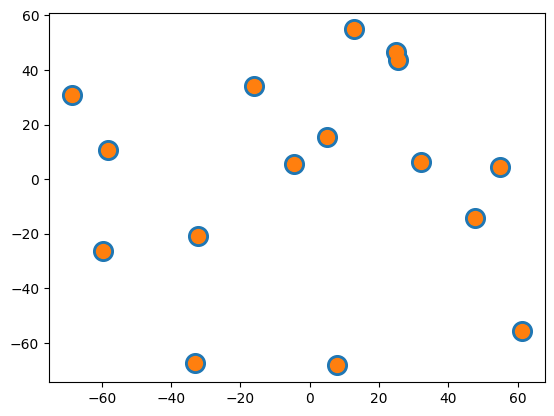

In [23]:
plt.scatter(x, y, s=200)
plt.scatter(-x2, -y2, s=100)
plt.show()

In [24]:
def plot_pca_projection(X_proj: DenseMatrix) -> Figure:
    """
    Вход: проекция данных X_proj (n × 2)
    Выход: объект Figure из Matplotlib
    """
    x = [X_proj[i][0] for i in range(X_proj.n())]
    y = [X_proj[i][1] for i in range(X_proj.n())]
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_title('PCA Projection')
    return fig

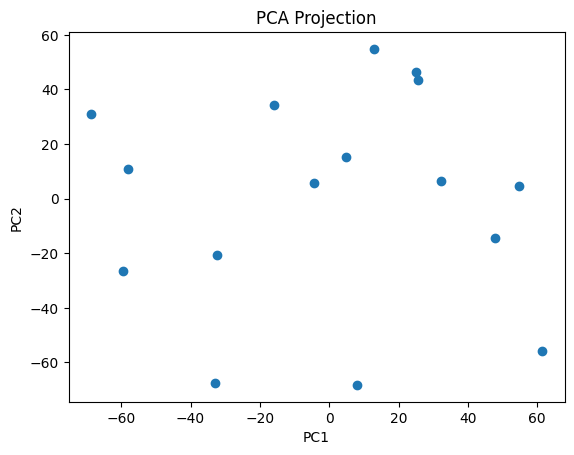

In [25]:
plot_pca_projection(pca(DenseMatrix(matrix), 2)[0])
plt.show()

In [26]:
def reconstruction_error(X_orig: DenseMatrix, X_recon: DenseMatrix) -> float:
    """
    Вход:
    X_orig: исходные данные (n × m)
    X_recon: восстановленные данные (n × m)
    Выход: среднеквадратическая ошибка MSE
    """
    n, m = X_orig.n(), X_orig.m()
    mse = 0.0
    for i in range(n):
        for j in range(m):
            mse += (X_orig[i][j] - X_recon[i][j]) ** 2
    mse /= (n * m)
    return mse

In [27]:
def reconstruct_from_pca(X_proj: DenseMatrix, Vs: DenseMatrix, cur_evals: list[float], means: list[float], k: int) -> DenseMatrix:
    # 1. Умножаем проекцию на транспонированные собственные векторы
    cur_vecs = DenseMatrix.cut_by_vector(Vs)
    idxs = sorted(range(len(cur_evals)), key=lambda i: -cur_evals[i])
    cur_vecs = DenseMatrix.concatenate_vectors(*[cur_vecs[i] for i in idxs[:k]])
    X_recon = X_proj * cur_vecs.T()
    # 2. Отменяем центрирование (добавляем среднее)
    n, m = X_recon.n(), X_recon.m()

    for i in range(n):
        for j in range(m):
            X_recon[i][j] = X_recon[i][j] + means[j]

    return X_recon

In [28]:
n_components = 2
dmatrix = DenseMatrix(matrix)
X_proj = pca(dmatrix, n_components)[0]
evals = find_eigenvalues(covariance_matrix(dmatrix))
evecs = find_eigenvectors(covariance_matrix(dmatrix), evals)
X_recon = reconstruct_from_pca(
    X_proj, evecs, evals, dmatrix.means(), n_components)

In [29]:
reconstruction_error(dmatrix, X_recon) ** 0.5

19.330930976759394

In [30]:
from sklearn.decomposition import PCA

In [31]:
def calculate_reconstruction_error(X, n_components_range):
    errors = []
    
    for n in n_components_range:
        pca = PCA(n_components=n)
        X_transformed = pca.fit_transform(X)
        
        X_reconstructed = pca.inverse_transform(X_transformed)
        
        mse = np.mean((X - X_reconstructed) ** 2)
        errors.append(mse)
    
    return errors

In [32]:
calculate_reconstruction_error(np.array(matrix), [2])[0] ** 0.5

np.float64(19.330930976759397)